
# IMPLEMENTED 
# 1. FEATURE EXTRACTION
# 2. RAN
# 3. DEMO TO SHOW RAN (BAR PLOT)
# 4. VISUALIZNG THE FILTERS


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import List


# Loading Image

In [ ]:
# Example: load one image
img_path = "/kaggle/input/bossbase/boss_256_0.4/cover/100.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape: (512, 512)

# Filters

In [ ]:
#SRM Filter

#(3×3 kernels)
srm_filters = [
    np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]]),  # horizontal diff
    np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]]),  # vertical diff
    np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])  # laplacian-like
]

In [ ]:
#Gabor Filter

def gabor_kernels(ksize=11):
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):  # 0,45,90,135 degrees
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kernels.append(kern.astype(np.float32))
    return kernels

gabor_kerns = gabor_kernels()

# Preprocessing Dataset

In [ ]:
class BossBaseDataset(Dataset):
    def __init__(self, cover_dir, stego_dir=None, transform=None):

        self.cover_files = sorted([
            os.path.join(cover_dir, f) for f in os.listdir(cover_dir) if f.lower().endswith(".png")
        ])
        self.stego_files = sorted([
            os.path.join(stego_dir, f) for f in os.listdir(stego_dir) if stego_dir and f.lower().endswith(".png")
        ]) if stego_dir else []

        self.transform = transform

        self.srm_filters = [
            np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]], dtype=np.float32),
            np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]], dtype=np.float32),
            np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]], dtype=np.float32)
        ]
        self.gabor_kerns = gabor_kernels(ksize=11)

        # precompute channel count for convenience (Cr + Cg + 1 grayscale)
        self.num_channels = len(self.srm_filters) + len(self.gabor_kerns) + 1

    def __len__(self):
        return len(self.cover_files) + len(self.stego_files)

    def _apply_filters(self, img):
        img_f = img.astype(np.float32)
        residuals = [cv2.filter2D(img_f, -1, k) for k in self.srm_filters]    # list of (H,W)
        gabors   = [cv2.filter2D(img_f, -1, k) for k in self.gabor_kerns]     # list of (H,W)
        residual_maps = np.stack(residuals, axis=2)   # (H, W, Cr)
        gabor_maps    = np.stack(gabors, axis=2)     # (H, W, Cg)
        return residual_maps, gabor_maps

    def __getitem__(self, idx):
        if idx < len(self.cover_files):
            img_path = self.cover_files[idx]
            label = 0.0  # cover
        else:
            img_path = self.stego_files[idx - len(self.cover_files)]
            label = 1.0  # stego

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape (H, W)
        if img is None:
            raise FileNotFoundError(f"Cannot load image: {img_path}")

        residual_maps, gabor_maps = self._apply_filters(img)

        gray_ch = img.astype(np.float32)[..., None]            # (H, W, 1)

        combined = np.concatenate([residual_maps, gabor_maps, gray_ch], axis=2)

        combined = combined.transpose(2, 0, 1).astype(np.float32)

        combined = combined / 255.0

        tensor = torch.from_numpy(combined)  # (C, H, W)

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, torch.tensor(label, dtype=torch.float32)

# Residual Attention Mechanism (v2)

**Residual Attention Block**

In [ ]:
class ResidualAttentionBlock(nn.Module):
    """Block: global pooling -> 1x1 conv (reduce) -> ReLU -> 1x1 conv (expand) -> Sigmoid -> channel reweight -> 1x1 conv -> GroupNorm -> ReLU -> add residual"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # (B,C,1,1)
        self.gate = nn.Sequential(
            nn.Conv2d(channels, reduced, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        self.out_conv = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, channels), num_channels=channels)

        self.last_weights = None   #to store the attention weights

    def forward(self, x):
        s = self.global_pool(x)        # (B, C, 1, 1)
        s = self.gate(s)               # (B, C, 1, 1)
        if not self.training:          # remove this to print the ran arch for each run
            print("Channel weights:", s.view(s.size(0), -1).detach().cpu().numpy())
        self.last_weights = s.detach().cpu().numpy()
        x_scaled = x * s             
        out = self.out_conv(x_scaled)
        out = self.norm(out)
        out = F.relu(out, inplace=True)
        return out + x              

**Convolution Block**

In [ ]:
class ConvBlockPool(nn.Module):
    """Conv -> ReLU -> MaxPool(2) with residual (skip downsampled)"""
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        if in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch),
                nn.AvgPool2d(kernel_size=2, stride=2)
            )
        else:
            self.skip = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        y = self.conv(x)
        y = self.norm(y)
        y = F.relu(y, inplace=True)
        y = self.pool(y)
        s = self.skip(x)
        return F.relu(y + s, inplace=True)


**Convolution Block**

In [ ]:
class ConvBlockGlobalPool(nn.Module):
    """Conv -> ReLU -> AdaptiveAvgPool2d(1) -> small gating -> channel-wise scaling -> residual add"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, channels), num_channels=channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.ch_gate = nn.Sequential(
            nn.Conv2d(channels, reduced, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.conv(x)
        y = self.norm(y)
        y = F.relu(y, inplace=True)
        p = self.pool(y)         # (B, C, 1, 1)
        g = self.ch_gate(p)      # (B, C, 1, 1)
        y2 = y * g               # gated
        return F.relu(y2 + x, inplace=True)

In [ ]:
class ResidualAttentionNet(nn.Module):
    """
    Outputs a feature map (B, C_latent, H_out, W_out)
    """
    def __init__(self, c_in, base_ch=32):
        super().__init__()
        self.init_conv = nn.Conv2d(c_in, base_ch, kernel_size=3, padding=1, bias=False)
        self.init_norm = nn.GroupNorm(num_groups=min(8, base_ch), num_channels=base_ch)

        self.att1 = ResidualAttentionBlock(base_ch, reduction=8)
        self.convpool = ConvBlockPool(base_ch, base_ch * 2)
        self.att2 = ResidualAttentionBlock(base_ch * 2, reduction=8)
        self.globalblock = ConvBlockGlobalPool(base_ch * 2, reduction=8)

        self.project = nn.Conv2d(base_ch * 2, base_ch * 4, kernel_size=1, bias=False)
        self.project_norm = nn.GroupNorm(num_groups=min(8, base_ch * 4), num_channels=base_ch * 4)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.init_norm(x)
        x = F.relu(x, inplace=True)

        x = self.att1(x)        # (B, base_ch, H, W)
        x = self.convpool(x)    # (B, base_ch*2, H/2, W/2)
        x = self.att2(x)        # (B, base_ch*2, H/2, W/2)
        x = self.globalblock(x) # (B, base_ch*2, H/2, W/2)

        x = self.project(x)
        x = self.project_norm(x)
        x = F.relu(x, inplace=True)
        return x

In [ ]:
cover_dir = "/kaggle/input/bossbase/boss_256_0.4/cover"
stego_dir = "/kaggle/input/bossbase/boss_256_0.4/stego"

dataset = BossBaseDataset(cover_dir, stego_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

c_in = dataset.num_channels

# instantiate RAN with that channel count
ran = ResidualAttentionNet(c_in, base_ch=32) #change this base channel value accordingly

#print(ran)  # print the model repr as you did earlier

# get one batch and run through RAN
for batch in dataloader:
    fused_input, labels = batch  # fused_input: (B, C, H, W)
    print("Fused input shape:", fused_input.shape)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ran = ran.to(device)
    fused_input = fused_input.to(device)

    attended_features = ran(fused_input)
    print("Attended features:", attended_features.shape)
    break

(B,C,H,W)
**B = BATCH
C = CHANNELS
H = Height
W = Width**


# Demo to Show Output of RAN

In [28]:
class TinyRAN(nn.Module):
    def __init__(self, c_in=1, base_ch=32):
        super().__init__()
        self.init_conv = nn.Conv2d(c_in, base_ch, 3, padding=1, bias=False)
        self.init_norm = nn.GroupNorm(num_groups=min(8, base_ch), num_channels=base_ch)
        self.att1 = ResidualAttentionBlock(base_ch, reduction=8)

    def forward(self, x):
        x = F.relu(self.init_norm(self.init_conv(x)))
        x = self.att1(x)
        return x

In [29]:
def visualize_attention_weights(model, cover_img, stego_img):
    with torch.no_grad():
        _ = model(cover_img.unsqueeze(0).unsqueeze(0))  # add batch+channel dims
        cover_w = model.att1.last_weights.squeeze()     # shape (C,)
        
        _ = model(stego_img.unsqueeze(0).unsqueeze(0))
        stego_w = model.att1.last_weights.squeeze()

    plt.figure(figsize=(12,5))
    idx = np.arange(len(cover_w))
    plt.bar(idx - 0.2, cover_w, width=0.4, label="Cover")
    plt.bar(idx + 0.2, stego_w, width=0.4, label="Stego")
    plt.xlabel("Channel index")
    plt.ylabel("Attention weight")
    plt.title("RAN Attention Weights: Cover vs Stego")
    plt.legend()
    plt.show()

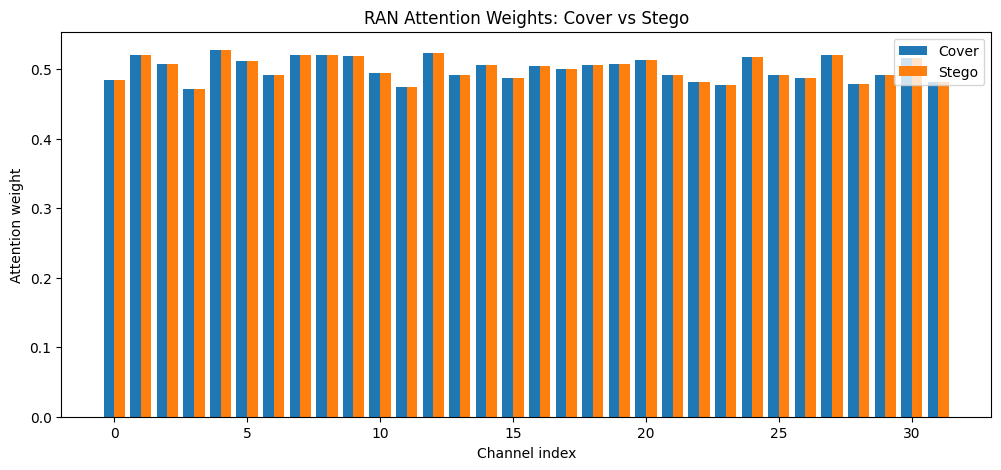

In [30]:
cover_dir = "/kaggle/input/bossbase/boss_256_0.4/cover/1.png"
stego_dir = "/kaggle/input/bossbase/boss_256_0.4/stego/1.png"

cover_img = cv2.imread(cover_dir, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
stego_img = cv2.imread(stego_dir, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

cover_img = torch.rand(64, 64)  # 64x64 grayscale
stego_img = cover_img.clone() + 0.01*torch.randn_like(cover_img)  # small noise
    
model = TinyRAN(c_in=1, base_ch=32)
visualize_attention_weights(model, cover_img, stego_img)

# Visualizing the Filters

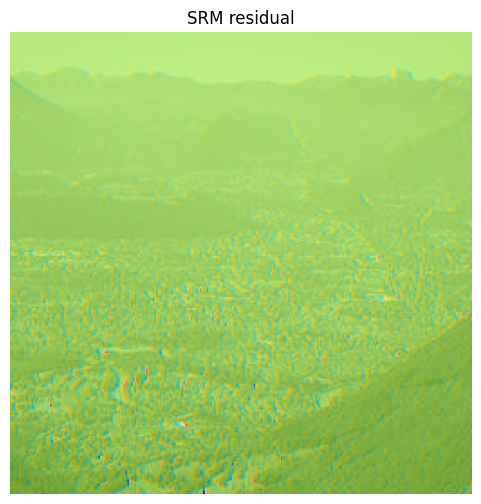

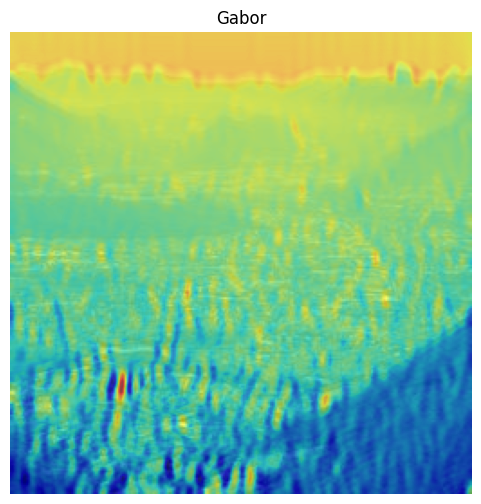

In [14]:
def extract_features(img, srm_filters, gabor_kerns):
    residual_maps = [cv2.filter2D(img.astype(np.float32), -1, f) for f in srm_filters]
    gabor_maps = [cv2.filter2D(img, cv2.CV_32F, k) for k in gabor_kerns]
    return np.stack(residual_maps, axis=-1), np.stack(gabor_maps, axis=-1)


def overlay_heatmap(original, feature_map, title="", alpha=0.6, cmap="jet"):
    """
    Overlay a feature map (residual or gabor) on top of the original image.
    """
    # Normalize feature map to [0, 1]
    norm_map = cv2.normalize(feature_map, None, 0, 1, cv2.NORM_MINMAX)

    plt.figure(figsize=(6,6))
    plt.imshow(original, cmap="gray")
    plt.imshow(norm_map, cmap=cmap, alpha=alpha)
    plt.title(title)
    plt.axis("off")
    plt.show()


residual_maps, gabor_maps = extract_features(img, srm_filters, gabor_kerns)
overlay_heatmap(img, residual_maps[..., 0], title="SRM residual")
overlay_heatmap(img, gabor_maps[..., 0], title="Gabor")

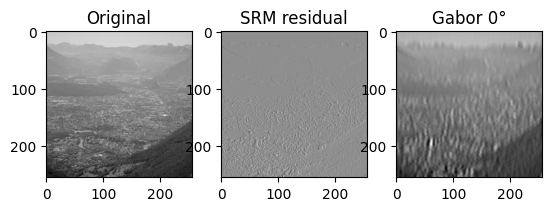

In [16]:
# visualize original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

# visualize one SRM residual
plt.subplot(1, 3, 2)
plt.imshow(residual_maps[..., 0], cmap='gray')
plt.title("SRM residual")

# visualize one Gabor map
plt.subplot(1, 3, 3)
plt.imshow(gabor_maps[..., 0], cmap='gray')
plt.title("Gabor 0°")
plt.show()
